In [61]:
import numpy as np
import cv2
import misc
from RL_networks import Stand_alone_net
import pickle
import pandas as pd


In [62]:
from sklearn.metrics import confusion_matrix

### Naive Random Walk, judt push the images to the networks and see if they can learn to extract information fro m a random combination of images.
In this implimintation we have the Syclop run a random walk on the image, we will see if a basic CNN or RNN network can work with a changing path over the images. 
<br> For each image a new, random, path will be initialized.
<br> This does not work at all, the networks run poorly compared to the case when the same random path is used for all images. 
<br> 

In [71]:
import importlib
importlib.reload(misc)

<module 'misc' from '/home/orram/Documents/GitHub/imagewalker/misc.py'>

In [64]:

from __future__ import division, print_function, absolute_import

# PyTorch libraries and modules
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn as nn
from mnist import MNIST

cifar = torchvision.datasets.CIFAR10('/home/orram/datasets/cifar10', train = True, download = True)
images, labels = cifar.data, cifar.targets
# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 128

validation_index=-5000

# Network Parameters
size=None
padding_size=(128,128)
# num_input = padding_size[0]*padding_size[1] # MNIST data input (img shape: 28*28)
num_classes = None 
# dropout = 0.25 # Dropout, probability to drop a unit

import matplotlib.pyplot as plt
%matplotlib notebook
import SYCLOP_env as syc



Files already downloaded and verified


In [65]:
#Define function for low resolution lens on syclop
def bad_res101(img,res):
    sh=np.shape(img)
    dwnsmp=cv2.resize(img,res, interpolation = cv2.INTER_CUBIC)
    upsmp = cv2.resize(dwnsmp,sh[:2], interpolation = cv2.INTER_CUBIC)
    return upsmp

<IPython.core.display.Javascript object>


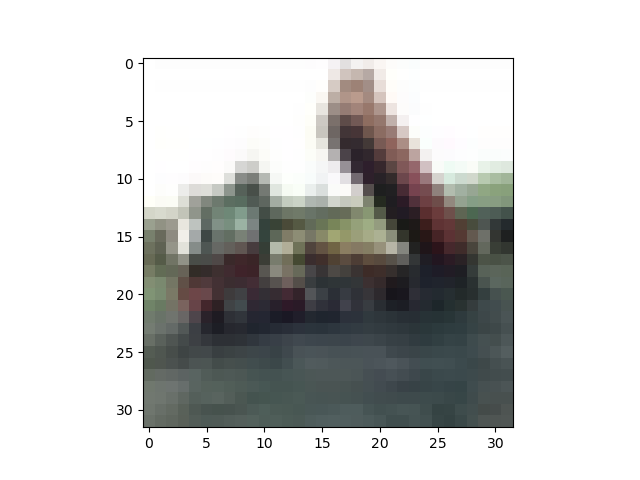

In [66]:
plt.figure()
plt.imshow(images[2])

In [67]:
import importlib
importlib.reload(misc)

<module 'misc' from '/home/orram/Documents/GitHub/imagewalker/misc.py'>

In [69]:
image = cv2.copyMakeBorder( images[42], 25, 25, 25, 25, cv2.BORDER_CONSTANT)

<IPython.core.display.Javascript object>


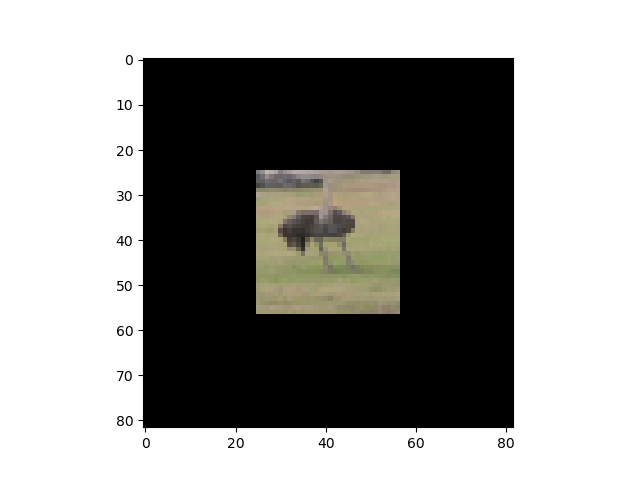

In [70]:
plt.figure()
plt.imshow(image)

<IPython.core.display.Javascript object>


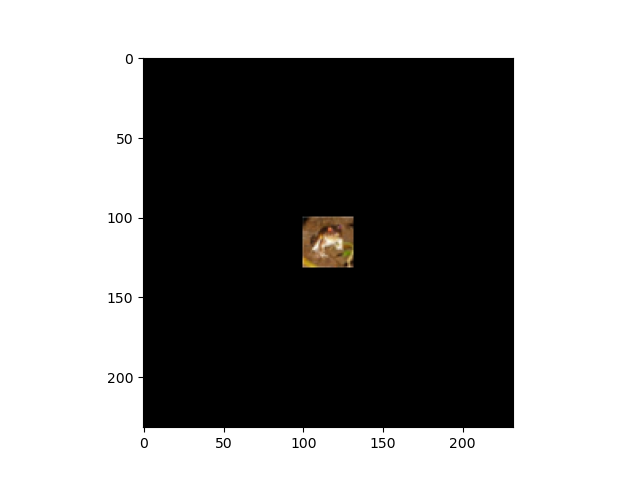

In [72]:
plt.figure()
plt.imshow(misc.build_cifar_padded(1./256*images[0]))

In [77]:
img=misc.build_cifar_padded(1./256*images[45])

In [83]:
scene = syc.Scene(image_matrix=img)
sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28,nchannels = 3)
agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

In [84]:
scene.image.shape


(232, 232, 3)

In [85]:
sensor.frame_view.shape

(56, 56, 3)

In [75]:
starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
steps  = []
for j in range(5):
    steps.append(starting_point*1)
    starting_point += np.random.randint(-5,5,2) 

q_sequence = np.array(steps).astype(int)
q_sequence

array([[88, 88],
       [88, 85],
       [91, 82],
       [87, 86],
       [87, 84]])

In [88]:
sensor.hp.resolution_fun = lambda x: bad_res101(x,(6,6))
imim=[]
dimim=[]
agent.set_manual_trajectory(manual_q_sequence=q_sequence)
for t in range(10):
    agent.manual_act()
    sensor.update(scene, agent)
    imim.append(sensor.central_frame_view)
    dimim.append(sensor.central_dvs_view)
    

<IPython.core.display.Javascript object>


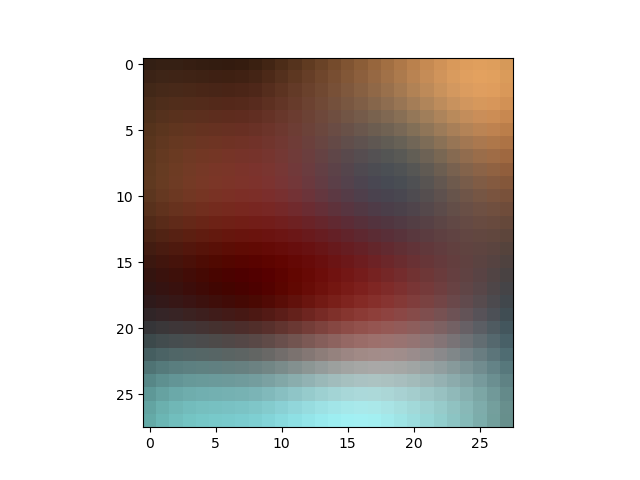

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


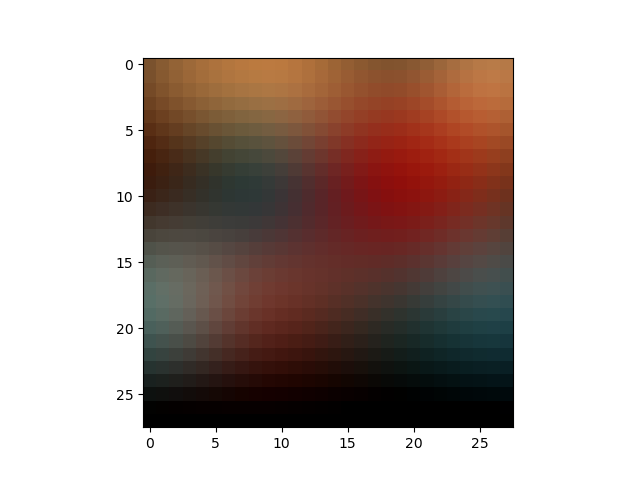

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


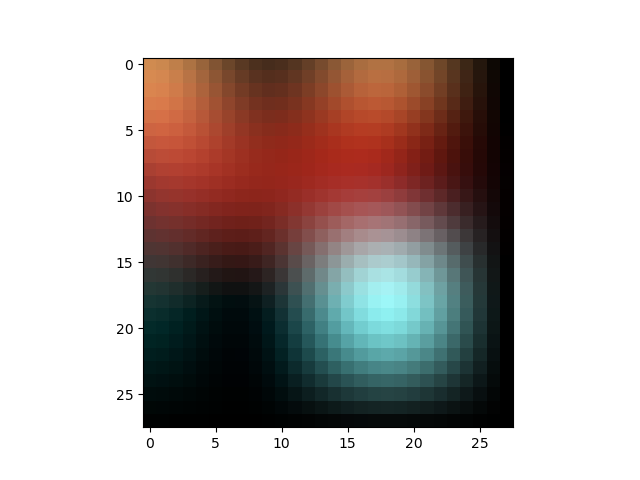

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


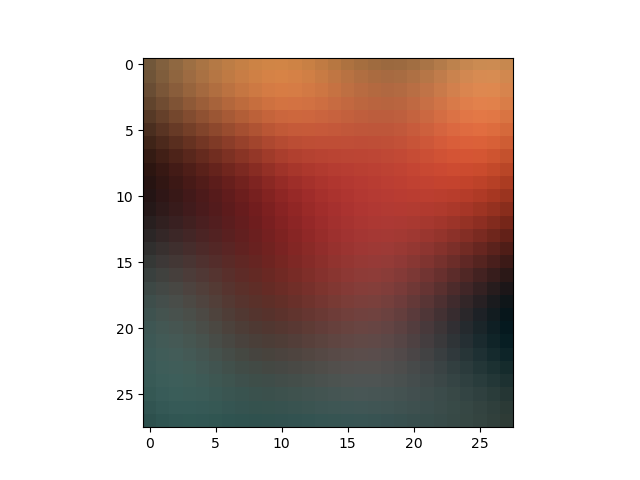

<IPython.core.display.Javascript object>


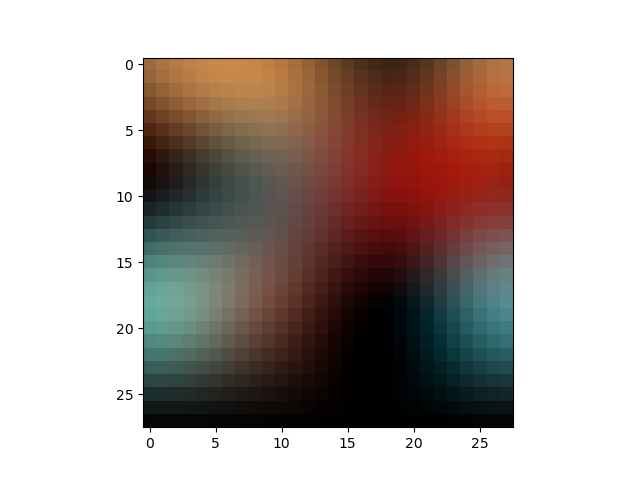

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [89]:
for i in range(5):
    plt.figure()
    plt.imshow(imim[i])

### Create a Dataset from the Syclops visual inputs
We are starting with a simple time series where the syclop starts from the same starting point, at the middle of the img on the x axis and the middle - 10 pixles on the y axis - (middle_point, middle_point - 10)
<br> Each time step the syclop will move one pixle up on the y axis, to a final point at (middle_point, middle_point + 10) and make a circular movement in the x direction.
<br> 

In [90]:
def create_dataset(images, labels, res, sample = 5, mixed_state = True, add_traject = True,
                   trajectory_list=None,return_datasets=False, add_seed = True, show_fig = False):
    '''
    Creates a torch dataloader object of syclop outputs 
    from a list of images and labels.
    
    Parameters
    ----------
    images : List object holding the images to proces
    labels : List object holding the labels
    res : resolution dawnsampling factor - to be used in cv.resize(orig_img, res)
    sample: the number of samples to have in syclop
    mixed_state : if False, use the same trajectory on every image.
    return_datasets: rerutns datasets rather than dataloaders
    Returns
    -------
    train_dataloader, test_dataloader - torch DataLoader class objects

    '''
    count = 0
    ts_images = []
    dvs_images = []
    q_seq = []
    count = 0
    if show_fig:
        #create subplot to hold examples from the dataset
        fig, ax = plt.subplots(2,5)
        i = 0 #indexises for the subplot for image and for syclop vision
    for img_num,img in enumerate(images):
        if add_seed:
            np.random.seed(torch.randint(1,20,(1,)))
        orig_img = np.reshape(img,[28,28])
        #Set the padded image
        img=misc.build_cifar_padded(1./256*images[45])
        if show_fig:
            if count < 5:
                ax[0,i].imshow(orig_img) 
                plt.title(labels[count])
        #Set the sensor and the agent
        scene = syc.Scene(image_matrix=img)
        sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28,nchannels = 3)
        agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
        #Setting the coordinates to visit
        if trajectory_list is None:
            starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
            steps  = []
            for j in range(5):
                steps.append(starting_point*1)
                starting_point += np.random.randint(-5,5,2) 

            if mixed_state:
                q_sequence = np.array(steps).astype(int)
            else:
                if count == 0:
                    q_sequence = np.array(steps).astype(int)
        else:
            q_sequence = np.array(trajectory_list[img_num]).astype(int)
        #Setting the resolution function - starting with the regular resolution
        sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
        #Create empty lists to store the syclops outputs
        imim=[]
        dimim=[]
        agent.set_manual_trajectory(manual_q_sequence=q_sequence)
        #Run Syclop for 20 time steps
        for t in range(5):
            agent.manual_act()
            sensor.update(scene, agent)
            imim.append(sensor.central_frame_view)
            dimim.append(sensor.central_dvs_view)
        #Create a unified matrix from the list
        if show_fig:
            if count < 5:
                ax[1,i].imshow(imim[0]) 
                plt.title(labels[count])
                i+=1
            

        imim = np.array(imim)
        dimim = np.array(dimim)
        #Add current proccessed image to lists
        ts_images.append(imim)
        dvs_images.append(dimim)
        q_seq.append(q_sequence)
        count += 1
        

    
    if add_traject: #If we add the trjectories the train list will become a list of lists, the images and the 
        #corrosponding trajectories, we will change the dataset structure as well. Note the the labels stay the same.
        ts_train = (ts_images[:55000], q_seq[:55000]) 
        train_labels = labels[:55000]
        ts_val = (ts_images[55000:], q_seq[55000:])
        val_labels = labels[55000:]

    else:
        ts_train = ts_images[:55000]
        train_labels = labels[:55000]
        ts_val = ts_images[55000:]
        val_labels = labels[55000:]

    dvs_train = dvs_images[:55000]
    dvs_val = dvs_images[55000:]
    
    class mnist_dataset(Dataset):
        def __init__(self, data, labels, add_traject = False, transform = None):

            self.data = data
            self.labels = labels

            self.add_traject = add_traject
            self.transform = transform
        def __len__(self):
            if self.add_traject: 
                return len(self.data[0]) 
            else: return len(self.data[0])


        def __getitem__(self, idx):
            '''
            args idx (int) :  index

            returns: tuple(data, label)
            '''
            if self.add_traject:
                img_data = self.data[0][idx] 
                traject_data = self.data[1][idx]
                label = self.labels[idx]
                return img_data, traject_data, label
            else:
                data = self.data[idx]



            if self.transform:
                data = self.transform(data)
                return data, label
            else:
                return data, label

        def dataset(self):
            return self.data
        def labels(self):
            return self.labels
        
    train_dataset = mnist_dataset(ts_train, train_labels,add_traject = True)
    test_dataset = mnist_dataset(ts_val, val_labels,add_traject = True)
    batch = 64
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch, shuffle = True)

    if return_datasets:
        return train_dataset, test_dataset
    else:
        return train_dataloader, test_dataloader, ts_train, train_labels


In [91]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(5,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [92]:
class CNN_one_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        img = img[:,0,:,:]
        img = img.unsqueeze(1)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [93]:
def train(train_dataloader, test_dataloader, net, epochs = 10):

    lr = 3e-3
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        net = net.cuda()
    
    train_loss = []
    test_loss = []
    test_accur = []
    for epoch in range(epochs):

        batch_loss = []
        for batch_idx, (data,targets) in enumerate(train_dataloader):
            if net.__class__.__name__ == 'RNN_Net':
                data = data.unsqueeze(2)
            if torch.cuda.is_available():
                data = data.to('cuda', non_blocking=True)
                targets = targets.to('cuda', non_blocking = True)
            #print(batch_idx, data.shape, targets.shape)

            optimizer.zero_grad()
            output = net(data.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())


        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                if net.__class__.__name__ == 'RNN_Net':
                    test_data = test_data.unsqueeze(2)
                if torch.cuda.is_available():
                    test_data = test_data.to('cuda', non_blocking=True)
                    test_targets = test_targets.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)

                test_output = net(test_data)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct.to('cpu')/len(test_targets))

            print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
    
    return train_loss, test_loss, test_accur

In [94]:
class RNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        hn = torch.zeros([1,data.shape[0],100]).double()
        if torch.cuda.is_available():
            hn = hn.to('cuda')
        #print(data.shape)
        for i in range(data.shape[1]):
            img = data[:,i,:,:,:]
            #print(img.shape)
            #plt.figure()
            #plt.imshow(img[0][0])
            img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
            img = self.pool(self.relu(self.bn2(self.conv2(img))))
            img = self.relu(self.bn3(self.conv3(img)))        
            img = img.view(img.shape[0],8*8*16)
            out, hn = self.gru(img.unsqueeze(0),hn)
            #print(out.shape)
        output = self.fc1(out[0, :, :])
        
        
        return output

In [95]:
class RNN_Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,4,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100, batch_first=True)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        batch_size, timesteps, C, H, W = data.size()
        img = datax.view(batch_size * timesteps, C, H, W)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        print(img.shape)
        img = img.view(img.shape[0],img.shape[1],8*8*16)
        out, hn = self.gru(img)
        output = self.fc1(hn.squeeze(0))
        
        
        return output

In [96]:
train_dataloader, test_dataloader, test_dataset = create_dataset(images, labels,res = 6,mixed_state = False)
train(train_dataloader, test_dataloader, RNN_net(), epochs = 10)

ValueError: cannot reshape array of size 3072 into shape (28,28)

### See the fluctuation differences when we run on the same trajectory and see set the reandom seed

Net RNN_Net Epoch :  1 	 loss : 0.11833295986460653 accuracy : 80.39953
Net RNN_Net Epoch :  2 	 loss : 0.1603222629408457 accuracy : 81.90269


<IPython.core.display.Javascript object>


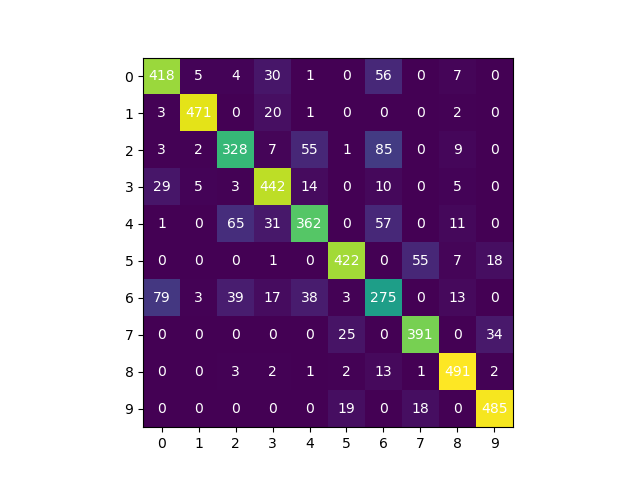

Net RNN_Net Epoch :  1 	 loss : 0.13042461559475735 accuracy : 81.01266
Net RNN_Net Epoch :  2 	 loss : 0.15128751393312562 accuracy : 81.803795


<IPython.core.display.Javascript object>


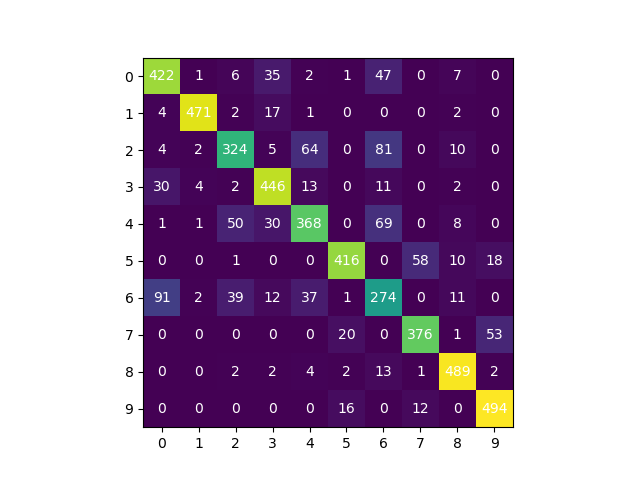

Net RNN_Net Epoch :  1 	 loss : 0.12295516956968076 accuracy : 79.56883
Net RNN_Net Epoch :  2 	 loss : 0.1212276069152189 accuracy : 81.60601


<IPython.core.display.Javascript object>


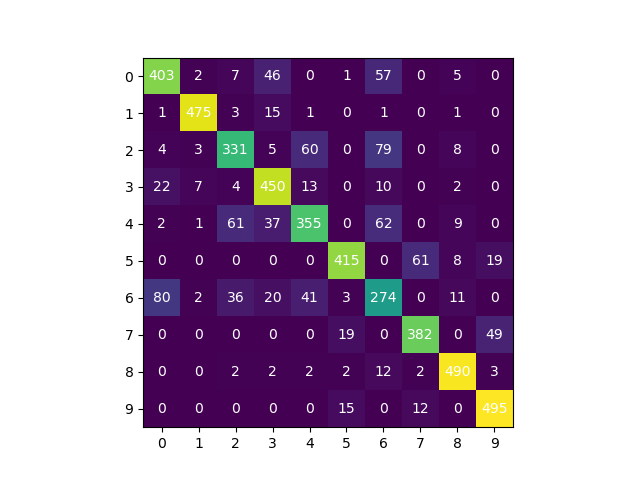

Net RNN_Net Epoch :  1 	 loss : 0.15386153149527573 accuracy : 81.230225
Net RNN_Net Epoch :  2 	 loss : 0.1040135377446001 accuracy : 81.86314


<IPython.core.display.Javascript object>


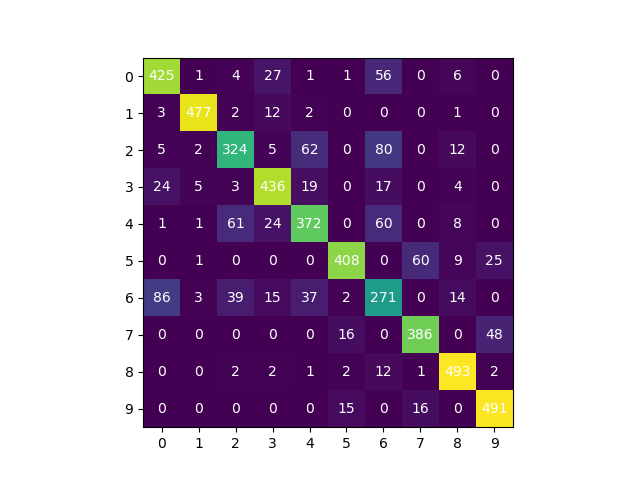

Net RNN_Net Epoch :  1 	 loss : 0.14649571407632744 accuracy : 80.30064
Net RNN_Net Epoch :  2 	 loss : 0.14221106228405359 accuracy : 81.803795


<IPython.core.display.Javascript object>


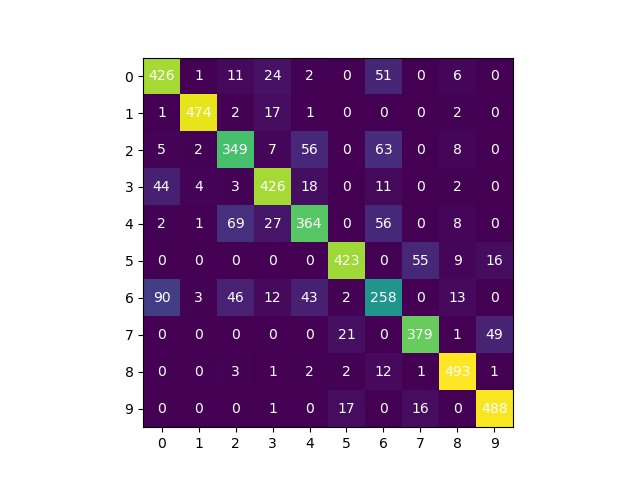

Net RNN_Net Epoch :  1 	 loss : 0.12751955463205714 accuracy : 80.57753
Net RNN_Net Epoch :  2 	 loss : 0.1688781001600662 accuracy : 81.60601


<IPython.core.display.Javascript object>


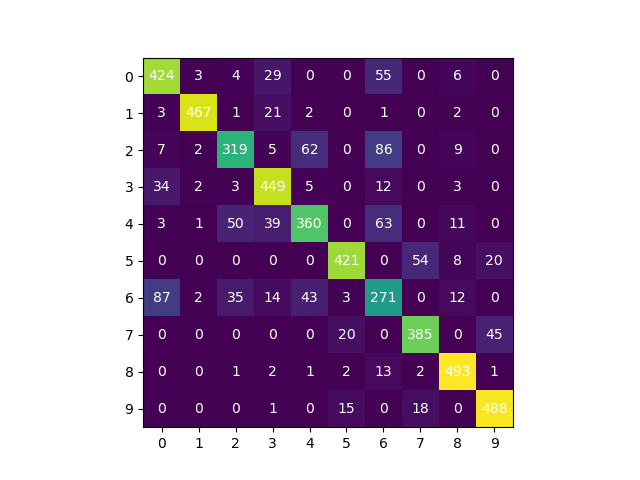

Net RNN_Net Epoch :  1 	 loss : 0.14535821804612736 accuracy : 80.85443
Net RNN_Net Epoch :  2 	 loss : 0.2373273853939974 accuracy : 81.5269


<IPython.core.display.Javascript object>


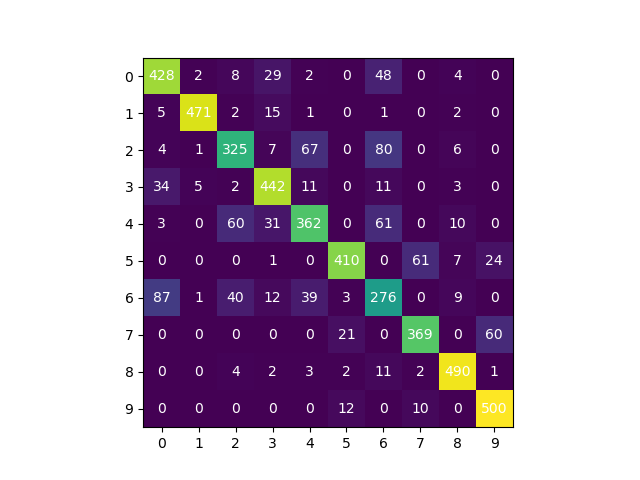

Net RNN_Net Epoch :  1 	 loss : 0.102929246595999 accuracy : 80.735756
Net RNN_Net Epoch :  2 	 loss : 0.11518449989459979 accuracy : 81.60601


<IPython.core.display.Javascript object>


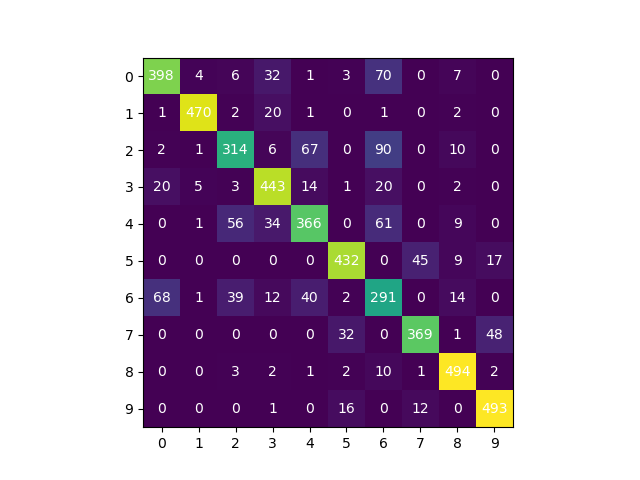

Net RNN_Net Epoch :  1 	 loss : 0.13228135682663184 accuracy : 81.34889
Net RNN_Net Epoch :  2 	 loss : 0.1261095493830441 accuracy : 81.88291


<IPython.core.display.Javascript object>


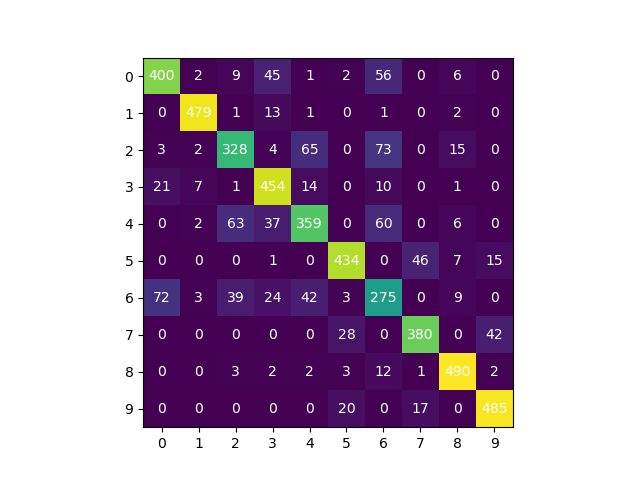

Net RNN_Net Epoch :  1 	 loss : 0.12381629859126812 accuracy : 80.87421
Net RNN_Net Epoch :  2 	 loss : 0.0962598410097295 accuracy : 82.00158


<IPython.core.display.Javascript object>


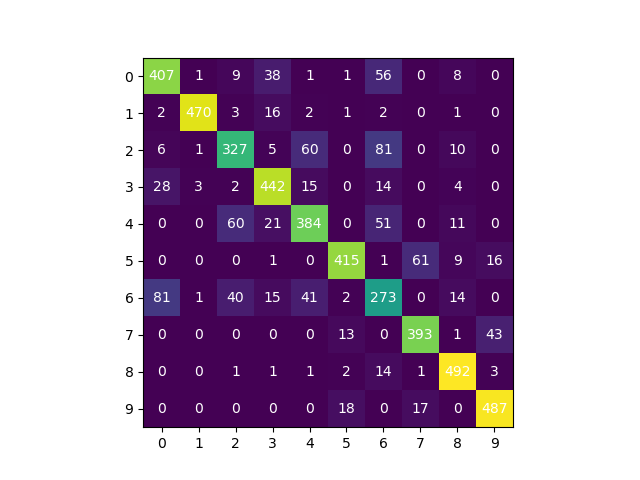

In [12]:
#Here we compare 10 different drewn treajectories
#Get the confusion to see what particular images each trajectory worked best

train_dataloader, test_dataloader, test_dataset = create_dataset(images, labels,res = 6,mixed_state = False)
indices = []
accur_list = []
for times in range(10):
    go = True
    while go:
        torch.manual_seed(0)
        lr = 3e-3
        epochs = 4
        net = RNN_Net().double()
        #net = CNN().double()
        optimizer = Adam(net.parameters(), lr = lr)
        loss_func = nn.CrossEntropyLoss()
        if torch.cuda.is_available():
            net = net.cuda()

        train_loss = []
        test_loss = []
        test_accur = []
        test_predictions = None
        for epoch in range(epochs):
            batch_loss = []
            for batch_idx, (data,targets) in enumerate(train_dataloader):
                if net.__class__.__name__ == 'RNN_Net':
                    data = data.unsqueeze(2)
                if torch.cuda.is_available():
                    data = data.to('cuda', non_blocking=True)
                    targets = targets.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)

                optimizer.zero_grad()
                output = net(data.double())
                loss = loss_func(output, targets)
                loss.backward()
                optimizer.step()
                batch_loss.append(loss.item())


            train_loss.append(np.mean(batch_loss))

            if epoch%1 == 0:
                correct = 0
                test_batch_loss = []
                test_accuracy = []
                for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                    if net.__class__.__name__ == 'RNN_Net':
                        test_data = test_data.unsqueeze(2)
                    if torch.cuda.is_available():
                        test_data = test_data.to('cuda', non_blocking=True)
                        test_targets = test_targets.to('cuda', non_blocking = True)
                    #print(batch_idx, data.shape, targets.shape)

                    test_output = net(test_data)
                    loss = loss_func(test_output, test_targets)
                    test_batch_loss.append(loss.item())
                    test_pred = test_output.data.max(1, keepdim = True)[1]
                    correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                    test_accuracy.append(100.*correct.to('cpu')/len(test_targets))
                    if batch_idx == 0:
                        test_predictions = test_pred.squeeze(1)
                    else:
                        test_predictions = torch.cat((test_predictions, test_pred.squeeze(1)), dim = 0)

                print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
                test_loss.append(np.mean(test_batch_loss))
                test_accur.append(np.mean(test_accuracy))
            if np.round(test_accur[-1]) == 82:
                break
        if test_accur[-1] < 84:
            if np.round(test_accur[-1]) >= 82:
                go = False
                #plot confusion matricx and extract the indices where the mistakes where made 
                test_predictions = test_predictions.cpu().detach().numpy().tolist()
                #test_predictions.tolist()
                targets = test_dataset.labels.tolist()
                confusion = confusion_matrix(targets, test_predictions)

                fig, ax = plt.subplots()
                im = ax.imshow(confusion)
                ax.set_xticks(np.arange(10))
                ax.set_yticks(np.arange(10))
                ax.set_xticklabels(np.arange(0,10))
                ax.set_yticklabels(np.arange(0,10))
                plt.savefig('no_restart_{}.png'.format(times))
                # Loop over data dimensions and create text annotations.
                for i in range(10):
                    for j in range(10):
                        text = ax.text(j, i, confusion[i, j],
                                       ha="center", va="center", color="w")
                mistaken = np.where(np.array(test_predictions) != np.array(targets))[0].tolist()
                indices.append(mistaken)
                accur_list.append(test_accur[-1])




In [13]:

#Build a matrix to hold the number of shared indices where the network was wrong (0d), number of overall 
#mistakes for trajectory i is on the diagonal
indices1 = indices
particular_confusion1 = np.ones([len(indices1), len(indices1)])
for i in range(len(indices1)):
    for j in range(len(indices1)):
        particular_confusion1[i,j] = len([r for r in indices1[i] if r in indices1[j]])
print(particular_confusion1)

    

[[915. 772. 768. 780. 761. 754. 775. 775. 763. 760.]
 [772. 920. 782. 769. 757. 753. 782. 762. 760. 761.]
 [768. 782. 930. 769. 767. 776. 779. 782. 766. 769.]
 [780. 769. 769. 917. 771. 756. 777. 757. 763. 761.]
 [761. 757. 767. 771. 920. 761. 773. 746. 750. 758.]
 [754. 753. 776. 756. 761. 923. 768. 749. 755. 762.]
 [775. 782. 779. 777. 773. 768. 927. 763. 760. 764.]
 [775. 762. 782. 757. 746. 749. 763. 930. 765. 755.]
 [763. 760. 766. 763. 750. 755. 760. 765. 916. 745.]
 [760. 761. 769. 761. 758. 762. 764. 755. 745. 910.]]


In [14]:


#Get the overall statistics:
#First, divide by the number of mistakes to get the percentage
for i in range(len(indices1)):
    particular_confusion1[i,:] /= particular_confusion1[i,i]
#get only the lower triangle
mean_confusion1 = np.tril(particular_confusion1, -1)
#Reshape to be a list

mean_confusion1 = mean_confusion1.reshape(particular_confusion1.shape[0] * particular_confusion1.shape[1])
mean_confusion1 = mean_confusion1.tolist()
#Delate all 0's from list
mean_confusion1 = [k for k in mean_confusion1 if k!=0]
#Now get the mean
std_confusion1 = np.round(np.std(mean_confusion1), decimals = 3)
mean_confusion1 = np.mean(mean_confusion1)

print('Mean Accuracy = {}, std = {}\n'.format(np.mean(accur_list), np.std(accur_list)))
print('Mean % of shared mistakes {} ({})\n'.format(mean_confusion1, std_confusion1))
print('Normalized shared confusion matrix:\n')
print(np.round(particular_confusion1,decimals = 2))


Mean Accuracy = 81.76029205322266, std = 0.15289640426635742

Mean % of shared mistakes 0.8306458033353837 (0.01)

Normalized shared confusion matrix:

[[1.   0.84 0.84 0.85 0.83 0.82 0.85 0.85 0.83 0.83]
 [0.84 1.   0.85 0.84 0.82 0.82 0.85 0.83 0.83 0.83]
 [0.83 0.84 1.   0.83 0.82 0.83 0.84 0.84 0.82 0.83]
 [0.85 0.84 0.84 1.   0.84 0.82 0.85 0.83 0.83 0.83]
 [0.83 0.82 0.83 0.84 1.   0.83 0.84 0.81 0.82 0.82]
 [0.82 0.82 0.84 0.82 0.82 1.   0.83 0.81 0.82 0.83]
 [0.84 0.84 0.84 0.84 0.83 0.83 1.   0.82 0.82 0.82]
 [0.83 0.82 0.84 0.81 0.8  0.81 0.82 1.   0.82 0.81]
 [0.83 0.83 0.84 0.83 0.82 0.82 0.83 0.84 1.   0.81]
 [0.84 0.84 0.85 0.84 0.83 0.84 0.84 0.83 0.82 1.  ]]


<IPython.core.display.Javascript object>


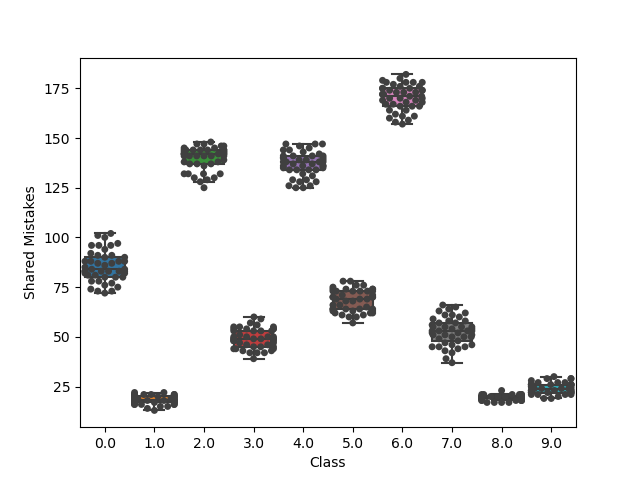

/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 68.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 42.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warn

<IPython.core.display.Javascript object>


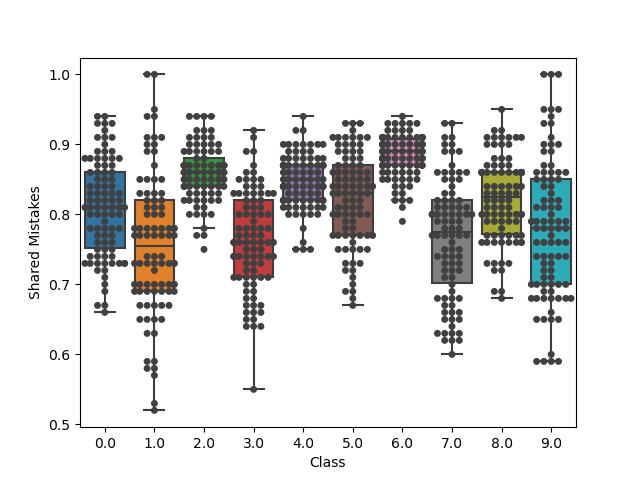

/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warni

<IPython.core.display.Javascript object>


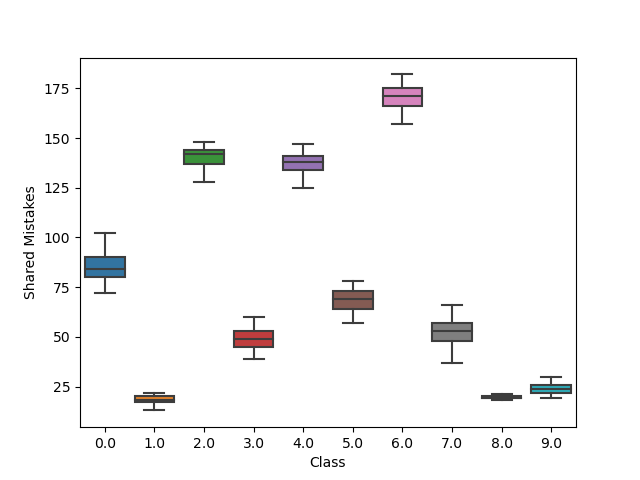

<IPython.core.display.Javascript object>


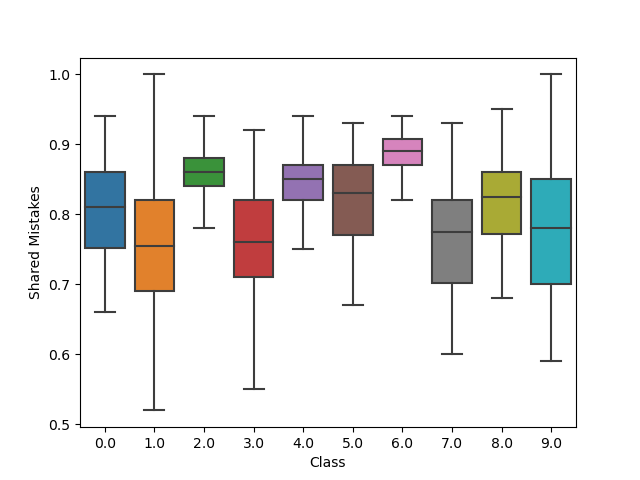

In [31]:
#Find the best trajectory and best seed for each class and also the variance in the common mistakes - in general,
#between the two best and between the two worst.
#Find the differences for each particular label - ex. for label 5 what missclassification did run 1 did 
#compared to run 2? i.e. can we find a trajectory that was particularly different for a distinct class? 
#or are all the classes exsibit simillar veriance? 

very_particular_confusion = np.ones([10,len(indices1), len(indices1)])
very_particular_confusion_percent = np.ones([10,len(indices1), len(indices1)])
run = 1
data_list = []
plot_list = pd.DataFrame(columns = ['Class', "Shared Mistakes"])
plot_list_percent = pd.DataFrame(columns = ['Class', "Shared Mistakes"])
for class_ in range(10):
    for i in range(len(indices1)):
        for j in range(len(indices1)):         
                class_indices = np.where(np.array(test_dataset.labels) == np.array(class_))[0]
                #get only the misslabeled indices for class_ from i
                i_indices = [k for k in indices1[i] if k in class_indices]
                #see how many are similar between i and j in class_
                similar = [l for l in i_indices if l in indices1[j]]
                very_particular_confusion[class_, i, j] = len(similar)
    #General statistics on the class########################################################################
    diagonal = np.diagonal(very_particular_confusion[class_,:,:])
    mean_class = np.mean(diagonal)
    std_class = np.round(np.std(diagonal), decimals = 3)
    best_class = np.min(diagonal)
    best_class_index = np.argmin(diagonal)
    worst_class = np.max(diagonal)
    worst_class_index = np.argmax(diagonal)
    #General Statistics on shared mistakes in the class ###################################################
    #The matrix is symetric so only one side matters
    triangulate = np.tril(very_particular_confusion[class_,:,:], -1)
    lower = triangulate.reshape(triangulate.shape[0]*triangulate.shape[1]).tolist()
    lower = [l for l in lower if l !=0] #Get only non-zero values
    #save lower to plot later 
    plot_data = np.array([np.ones(len(lower))*class_,lower]).T
    plot_data = pd.DataFrame(plot_data, columns = ['Class', "Shared Mistakes"])
    plot_list = plot_list.append(plot_data)
    mean_shared = np.mean(lower)
    std_shared = np.round(np.std(lower), decimals = 3)
    min_shared = np.min(triangulate[np.nonzero(triangulate)])
    r,t = np.where( triangulate==np.min(triangulate[np.nonzero(triangulate)]))
    min_shared_index = (int(r[0]),int(t[0]))
    max_shared = np.max(triangulate)
    max_shared_index = np.unravel_index(np.argmax(triangulate, axis=None), triangulate.shape)
    #Get % Matrix #########################################################################################
    very_particular_confusion_percent[class_, :,:] = very_particular_confusion[class_,:,:]*1
    for i in range(len(indices1)):
        very_particular_confusion_percent[class_, i, :] /= very_particular_confusion_percent[class_, i, i] 
        
    very_particular_confusion_percent = np.round(very_particular_confusion_percent, decimals = 2)
    temp = very_particular_confusion_percent[class_, :,:] * 1
    np.fill_diagonal(temp, 0) # zero out the diagonal
    temp = temp.reshape(temp.shape[0]*temp.shape[1]).tolist()
    no_diagonal = [l for l in temp if l !=0] #Get only non-zero values
    mean_shared = np.mean(no_diagonal)
    std_shared_per = np.round(np.std(no_diagonal), decimals = 3)
    min_shared_per = np.min(no_diagonal)
    min_shared_index_per = np.argmin(no_diagonal)
    max_shared_pre = np.max(no_diagonal)
    max_shared_index_per = np.argmax(no_diagonal)
    #save no_diagonal to plot later
    plot_data_percent = np.array([np.ones(len(no_diagonal))*class_,no_diagonal]).T
    plot_data_percent = pd.DataFrame(plot_data_percent, columns = ['Class', "Shared Mistakes"])
    plot_list_percent = plot_list_percent.append(plot_data_percent)
    #Find the BEST trajectory for this class ##############################################################
    #get the two best run (min number of mistakes)
    min_mistakes = np.partition(diagonal, 1)[:2]
    indx1 = np.argwhere(diagonal == min_mistakes[0])[0]
    indx2 = np.argwhere(diagonal == min_mistakes[1])[0]
    #Get the shared mistakes between them
    two_best_shared = very_particular_confusion_percent[class_,indx1, indx2][0]
    #print('On run {} - for class {} the two BEST trajectories misslabeled {} imgs \n {} were shared'.format(
    #                                                run, class_, min_mistakes, shared))
    #Find the WORST trajectory for this class ############################################################
    #get the two best run (min number of mistakes)
    max_mistakes = np.partition(diagonal, 1)[-2:]
    indx1 = np.argwhere(diagonal == max_mistakes[0])[0]
    indx2 = np.argwhere(diagonal == max_mistakes[1])[0]
    #Get the shared mistakes between them
    two_worst_shared = very_particular_confusion_percent[class_,indx1, indx2][0]
    #print('On run {} - for class {} the two WORST trajectories misslabeled {} imgs \n {} were shared'.format(
    #                                                run, class_, max_mistakes, shared))
    data_list.append([mean_class,
                      std_class,
                      best_class,
                      best_class_index,
                      worst_class,
                      worst_class_index,
                      mean_shared,
                      std_shared,
                      min_shared,
                      min_shared_index,
                      max_shared,
                      max_shared_index,
                      mean_shared,
                      std_shared_per,
                      min_shared_per,
                      min_shared_index_per,
                      max_shared_pre,
                      max_shared_index_per,
                      two_best_shared,
                      two_worst_shared
                     ])
Database = pd.DataFrame(data_list,  columns = [
                    'Mean Class','std Class',
                    'Best Run','Best Run Index', 'Worst Run','Worst Run Index', 
                    'Mean Shared', 'std Shared','Min Shared', 'Min Shared Index','Max Shared','Max Shared Index',
                    'Mean Shared %', 'std Shared %', 'Min Shared %','Min Shared % Index', 'Max Shared %','Max Shared % Index',
                     '2 Best shared %', '2 Worst Shared %',])
Database
#plot very_particular_confusion ################################################################################
import seaborn as sns
plt.figure()
ax = sns.boxplot(x="Class", y="Shared Mistakes", data=pd.DataFrame(plot_list), showfliers = False)
ax = sns.swarmplot(x="Class", y="Shared Mistakes", data=pd.DataFrame(plot_list), color=".25")
plt.show()
plt.savefig('confusion_fmnist_no_restart_{}.png'.format(times))
#plot very_particular_confusion_percentage ######################################################################
plt.figure()
ax = sns.boxplot(x="Class", y="Shared Mistakes", data=plot_list_percent, showfliers = False)
ax = sns.swarmplot(x="Class", y="Shared Mistakes", data=plot_list_percent, color=".25")
plt.show()
plt.savefig('confusion_percent_fmnist_no_restart_{}.png'.format(times))
plt.figure()
ax = sns.boxplot(x="Class", y="Shared Mistakes", data=pd.DataFrame(plot_list), showfliers = False)
plt.show()
plt.savefig('confusion_fmnist_no_restart2_{}.png'.format(times))
#plot very_particular_confusion_percentage ######################################################################
plt.figure()
ax = sns.boxplot(x="Class", y="Shared Mistakes", data=plot_list_percent, showfliers = False)
plt.show()
plt.savefig('confusion_percent_fmnist_no_restart2_{}.png'.format(times))

In [32]:
Database = Database.round(decimals = 2)
Database.to_pickle('No_restart_sum_data.pickle')
Database

,Mean Class,std Class,Best Run,Best Run Index,Worst Run,Worst Run Index,Mean Shared,std Shared,Min Shared,Min Shared Index,Max Shared,Max Shared Index,Mean Shared %,std Shared %,Min Shared %,Min Shared % Index,Max Shared %,Max Shared % Index,2 Best shared %,2 Worst Shared %
0,105.9,11.18,93.0,6,123.0,7,0.81,7.66,72.0,"(4, 1)",102.0,"(7, 2)",0.81,0.07,0.66,67,0.94,33,0.78,0.80
1,24.5,3.47,18.0,8,30.0,5,0.76,2.09,13.0,"(8, 3)",22.0,"(1, 0)",0.76,0.10,0.52,66,1.00,78,0.72,0.73
2,163.1,8.70,141.0,4,176.0,7,0.86,5.68,125.0,"(9, 4)",148.0,"(7, 1)",0.86,0.04,0.75,67,0.94,37,0.91,0.87
3,65.0,7.46,54.0,8,82.0,4,0.76,4.90,39.0,"(8, 2)",60.0,"(4, 3)",0.76,0.07,0.55,43,0.92,49,0.72,1.00
4,161.8,7.74,143.0,9,172.0,2,0.85,6.04,125.0,"(9, 5)",147.0,"(2, 0)",0.85,0.04,0.75,26,0.94,81,0.90,0.88
5,83.4,8.14,69.0,8,95.0,3,0.82,5.44,57.0,"(8, 7)",78.0,"(6, 3)",0.82,0.06,0.67,34,0.93,75,0.83,0.81
6,193.2,7.55,176.0,7,209.0,4,0.88,6.27,157.0,"(8, 7)",182.0,"(4, 3)",0.88,0.03,0.79,42,0.94,67,0.90,0.91
7,69.0,7.77,57.0,9,81.0,6,0.77,6.82,37.0,"(9, 0)",66.0,"(6, 1)",0.77,0.08,0.60,45,0.93,82,0.65,0.81
8,23.5,1.63,21.0,7,26.0,1,0.82,1.24,17.0,"(5, 2)",23.0,"(8, 6)",0.82,0.06,0.68,22,0.95,27,0.90,0.76
9,31.4,4.63,22.0,6,37.0,0,0.78,2.70,19.0,"(6, 1)",30.0,"(9, 8)",0.78,0.10,0.59,1,1.00,54,0.86,0.68


In [33]:
very_particular_confusion

array([[[103.,  83.,  96.,  84.,  76.,  80.,  83.,  94.,  91.,  91.],
        [ 83.,  99.,  92.,  73.,  72.,  80.,  78.,  87.,  88.,  85.],
        [ 96.,  92., 118.,  86.,  83.,  88.,  87., 102., 101.,  96.],
        [ 84.,  73.,  86.,  96.,  74.,  80.,  77.,  90.,  88.,  82.],
        [ 76.,  72.,  83.,  74.,  95.,  78.,  73.,  81.,  83.,  84.],
        [ 80.,  80.,  88.,  80.,  78.,  97.,  75.,  90.,  88.,  83.],
        [ 83.,  78.,  87.,  77.,  73.,  75.,  93.,  83.,  81.,  82.],
        [ 94.,  87., 102.,  90.,  81.,  90.,  83., 123., 100.,  96.],
        [ 91.,  88., 101.,  88.,  83.,  88.,  81., 100., 121.,  97.],
        [ 91.,  85.,  96.,  82.,  84.,  83.,  82.,  96.,  97., 114.]],

       [[ 26.,  22.,  17.,  17.,  18.,  20.,  19.,  19.,  15.,  18.],
        [ 22.,  26.,  18.,  18.,  18.,  19.,  20.,  17.,  15.,  19.],
        [ 17.,  18.,  22.,  16.,  18.,  21.,  20.,  18.,  17.,  20.],
        [ 17.,  18.,  16.,  20.,  17.,  16.,  18.,  14.,  13.,  16.],
        [ 18.,  18

In [34]:
very_particular_confusion_percent

array([[[1.  , 0.81, 0.93, 0.82, 0.74, 0.78, 0.81, 0.91, 0.88, 0.88],
        [0.84, 1.  , 0.93, 0.74, 0.73, 0.81, 0.79, 0.88, 0.89, 0.86],
        [0.81, 0.78, 1.  , 0.73, 0.7 , 0.75, 0.74, 0.86, 0.86, 0.81],
        [0.88, 0.76, 0.9 , 1.  , 0.77, 0.83, 0.8 , 0.94, 0.92, 0.85],
        [0.8 , 0.76, 0.87, 0.78, 1.  , 0.82, 0.77, 0.85, 0.87, 0.88],
        [0.82, 0.82, 0.91, 0.82, 0.8 , 1.  , 0.77, 0.93, 0.91, 0.86],
        [0.89, 0.84, 0.94, 0.83, 0.78, 0.81, 1.  , 0.89, 0.87, 0.88],
        [0.76, 0.71, 0.83, 0.73, 0.66, 0.73, 0.67, 1.  , 0.81, 0.78],
        [0.75, 0.73, 0.83, 0.73, 0.69, 0.73, 0.67, 0.83, 1.  , 0.8 ],
        [0.8 , 0.75, 0.84, 0.72, 0.74, 0.73, 0.72, 0.84, 0.85, 1.  ]],

       [[1.  , 0.85, 0.65, 0.65, 0.69, 0.77, 0.73, 0.73, 0.58, 0.69],
        [0.85, 1.  , 0.69, 0.69, 0.69, 0.73, 0.77, 0.65, 0.58, 0.73],
        [0.77, 0.82, 1.  , 0.73, 0.82, 0.95, 0.91, 0.82, 0.77, 0.91],
        [0.85, 0.9 , 0.8 , 1.  , 0.85, 0.8 , 0.9 , 0.7 , 0.65, 0.8 ],
        [0.78, 0.7

### See the changes from different trajectories - are they more sugnificant then the random ones? 

Net RNN_Net Epoch :  1 	 loss : 0.2418814626837536 accuracy : 80.241295
Net RNN_Net Epoch :  2 	 loss : 0.2967637159671319 accuracy : 81.50712


<IPython.core.display.Javascript object>


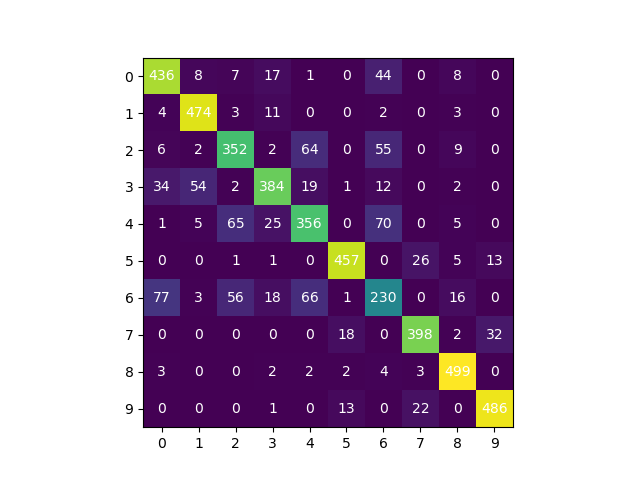

Net RNN_Net Epoch :  1 	 loss : 0.35112313731749906 accuracy : 77.294304
Net RNN_Net Epoch :  2 	 loss : 0.42125210896473164 accuracy : 78.06567
Net RNN_Net Epoch :  3 	 loss : 0.2136411743553595 accuracy : 79.9644
Net RNN_Net Epoch :  4 	 loss : 0.23945289230808806 accuracy : 80.34019
Net RNN_Net Epoch :  1 	 loss : 0.3957378602632003 accuracy : 77.94699
Net RNN_Net Epoch :  2 	 loss : 0.27861211460878843 accuracy : 79.76662
Net RNN_Net Epoch :  3 	 loss : 0.1400488916177588 accuracy : 80.81487
Net RNN_Net Epoch :  4 	 loss : 0.18827737142437562 accuracy : 81.32912
Net RNN_Net Epoch :  1 	 loss : 0.18891929649854647 accuracy : 81.74446


<IPython.core.display.Javascript object>


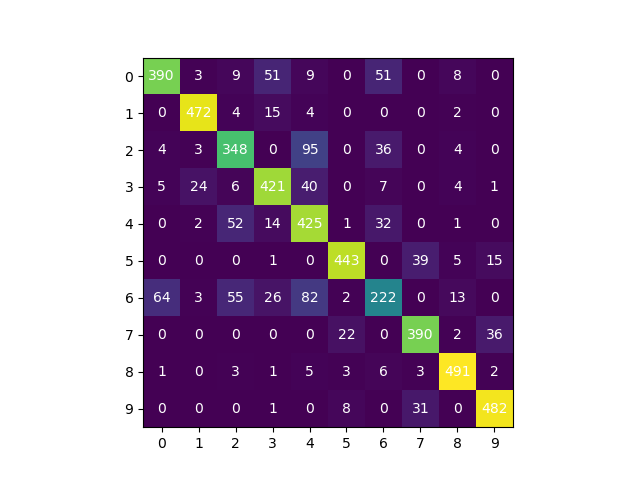

Net RNN_Net Epoch :  1 	 loss : 0.17960053997024567 accuracy : 80.99288
Net RNN_Net Epoch :  2 	 loss : 0.23855958130610355 accuracy : 81.56645


<IPython.core.display.Javascript object>


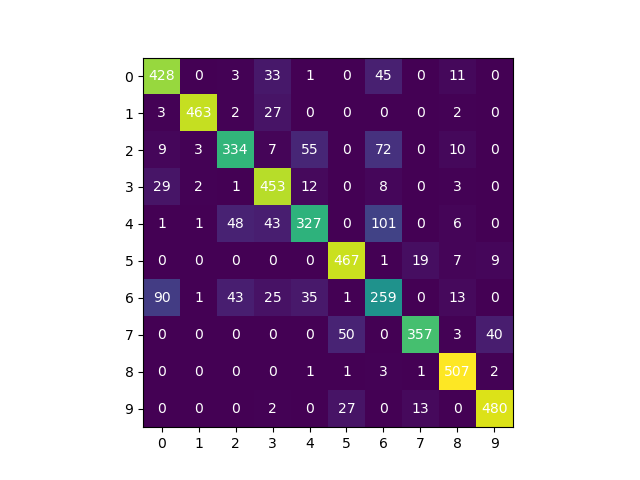

Net RNN_Net Epoch :  1 	 loss : 0.15844815568958673 accuracy : 80.34019
Net RNN_Net Epoch :  2 	 loss : 0.17956659840388942 accuracy : 82.49605


<IPython.core.display.Javascript object>


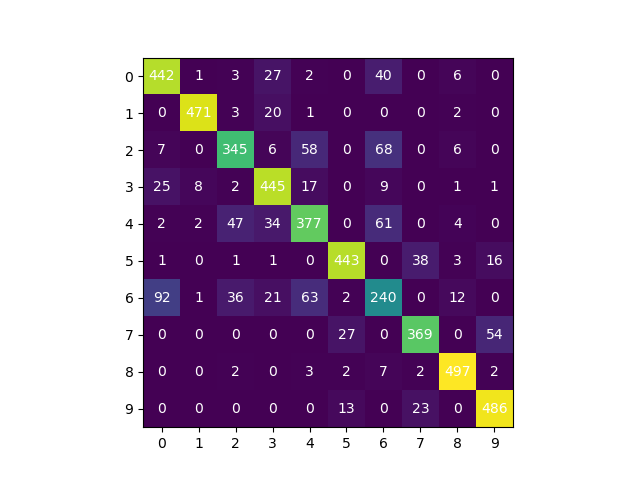

Net RNN_Net Epoch :  1 	 loss : 0.20692405966885688 accuracy : 79.86551
Net RNN_Net Epoch :  2 	 loss : 0.3246129845240402 accuracy : 80.12263
Net RNN_Net Epoch :  3 	 loss : 0.23231585906615254 accuracy : 80.735756
Net RNN_Net Epoch :  4 	 loss : 0.13375659288286207 accuracy : 82.080696


<IPython.core.display.Javascript object>


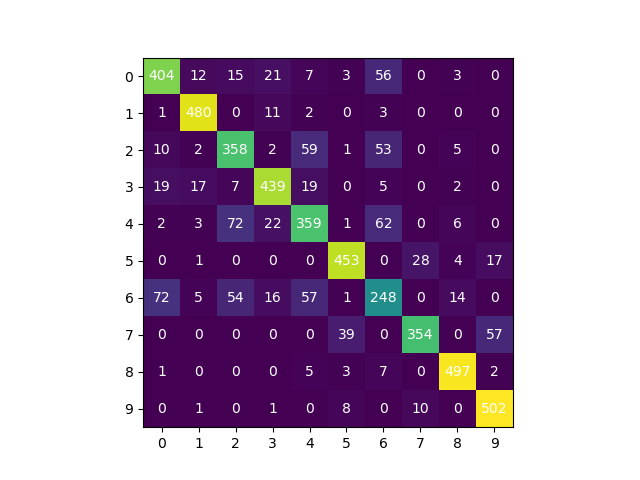

Net RNN_Net Epoch :  1 	 loss : 0.4223201198960942 accuracy : 80.53797
Net RNN_Net Epoch :  2 	 loss : 0.2370626101200923 accuracy : 81.74446


<IPython.core.display.Javascript object>


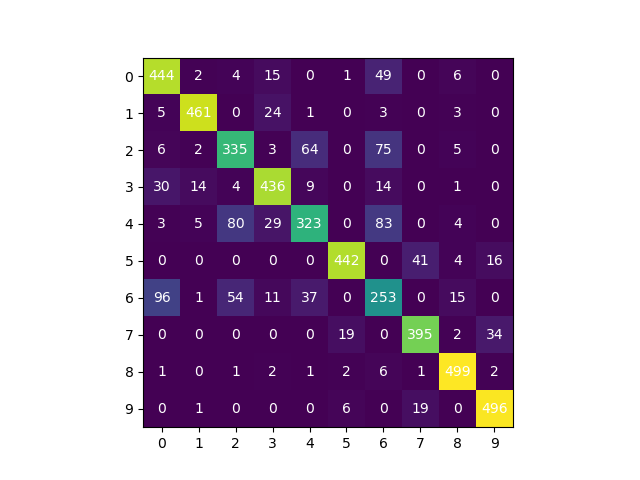

Net RNN_Net Epoch :  1 	 loss : 0.2925265232076079 accuracy : 80.49842
Net RNN_Net Epoch :  2 	 loss : 0.2771991263143162 accuracy : 80.95332
Net RNN_Net Epoch :  3 	 loss : 0.1137620082987491 accuracy : 81.78402


<IPython.core.display.Javascript object>


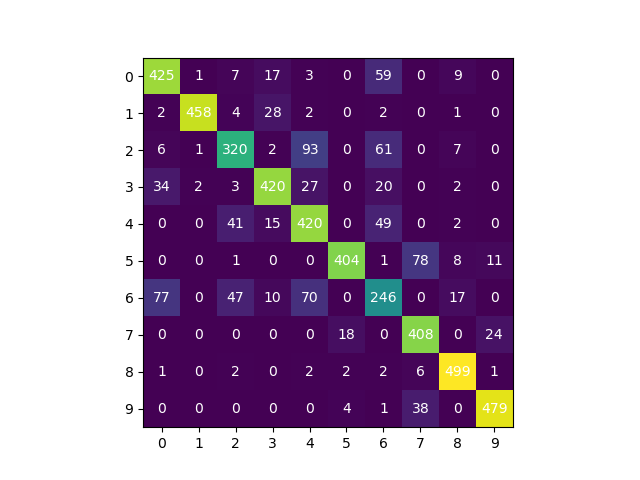

Net RNN_Net Epoch :  1 	 loss : 0.12108464933906374 accuracy : 80.49842
Net RNN_Net Epoch :  2 	 loss : 0.13057126886636589 accuracy : 81.28956
Net RNN_Net Epoch :  3 	 loss : 0.1507491876381844 accuracy : 82.792725
Net RNN_Net Epoch :  4 	 loss : 0.05404285357985405 accuracy : 82.51582


<IPython.core.display.Javascript object>


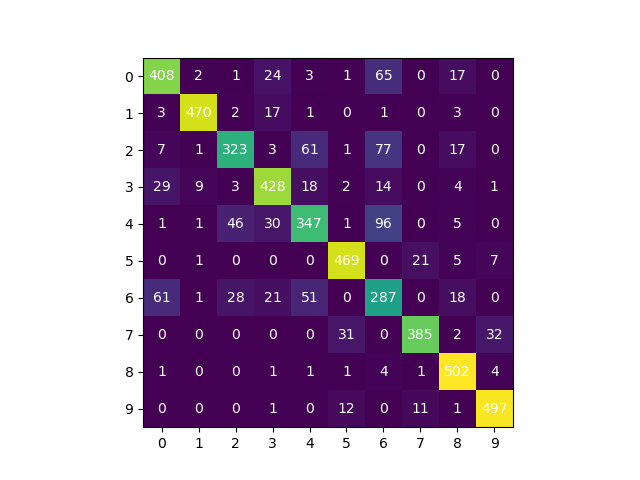

Net RNN_Net Epoch :  1 	 loss : 0.2537624347018807 accuracy : 79.845726
Net RNN_Net Epoch :  2 	 loss : 0.21000588705185794 accuracy : 81.54668


<IPython.core.display.Javascript object>


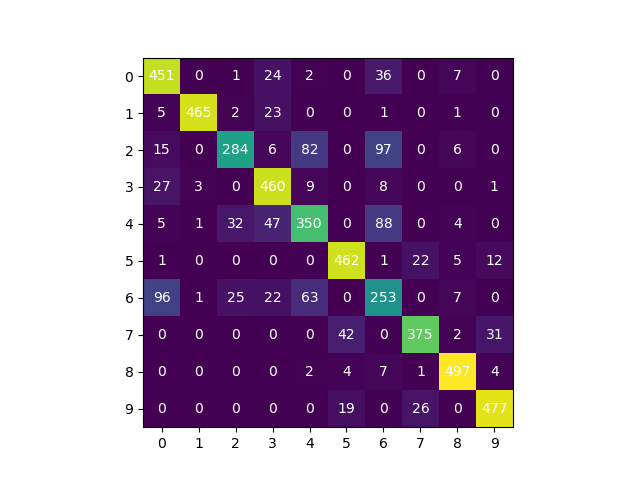

Net RNN_Net Epoch :  1 	 loss : 0.3380606237080804 accuracy : 80.06329
Net RNN_Net Epoch :  2 	 loss : 0.34263985121114743 accuracy : 80.57753
Net RNN_Net Epoch :  3 	 loss : 0.17038707956914276 accuracy : 82.59494
Net RNN_Net Epoch :  4 	 loss : 0.13972166977637474 accuracy : 82.93117


<IPython.core.display.Javascript object>


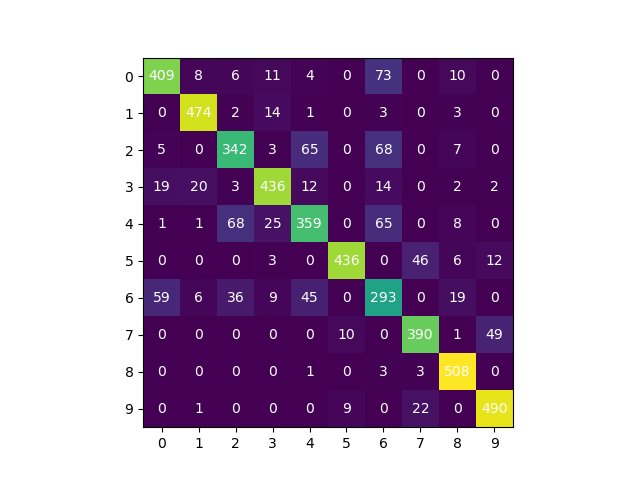

In [12]:
#Here we drew 10 different random networks


indices = []
accur_list = []
for times in range(10):
    go = True
    while go:
        train_dataloader, test_dataloader, test_dataset = create_dataset(images, labels,res = 6,mixed_state = False)
        torch.manual_seed(0)
        lr = 3e-3
        epochs = 4
        net = RNN_Net().double()
        #net = CNN().double()
        optimizer = Adam(net.parameters(), lr = lr)
        loss_func = nn.CrossEntropyLoss()
        if torch.cuda.is_available():
            net = net.cuda()

        train_loss = []
        test_loss = []
        test_accur = []
        test_predictions = None
        for epoch in range(epochs):
            batch_loss = []
            for batch_idx, (data,targets) in enumerate(train_dataloader):
                if net.__class__.__name__ == 'RNN_Net':
                    data = data.unsqueeze(2)
                if torch.cuda.is_available():
                    data = data.to('cuda', non_blocking=True)
                    targets = targets.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)

                optimizer.zero_grad()
                output = net(data.double())
                loss = loss_func(output, targets)
                loss.backward()
                optimizer.step()
                batch_loss.append(loss.item())


            train_loss.append(np.mean(batch_loss))

            if epoch%1 == 0:
                correct = 0
                test_batch_loss = []
                test_accuracy = []
                for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                    if net.__class__.__name__ == 'RNN_Net':
                        test_data = test_data.unsqueeze(2)
                    if torch.cuda.is_available():
                        test_data = test_data.to('cuda', non_blocking=True)
                        test_targets = test_targets.to('cuda', non_blocking = True)
                    #print(batch_idx, data.shape, targets.shape)

                    test_output = net(test_data)
                    loss = loss_func(test_output, test_targets)
                    test_batch_loss.append(loss.item())
                    test_pred = test_output.data.max(1, keepdim = True)[1]
                    correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                    test_accuracy.append(100.*correct.to('cpu')/len(test_targets))
                    if batch_idx == 0:
                        test_predictions = test_pred.squeeze(1)
                    else:
                        test_predictions = torch.cat((test_predictions, test_pred.squeeze(1)), dim = 0)

                print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
                test_loss.append(np.mean(test_batch_loss))
                test_accur.append(np.mean(test_accuracy))
            if np.round(test_accur[-1]) == 82:
                break
        if test_accur[-1] < 84:
            if np.round(test_accur[-1]) >= 82:
                go = False
                #plot confusion matricx and extract the indices where the mistakes where made 
                test_predictions = test_predictions.cpu().detach().numpy().tolist()
                #test_predictions.tolist()
                targets = test_dataset.labels.tolist()
                confusion = confusion_matrix(targets, test_predictions)

                fig, ax = plt.subplots()
                im = ax.imshow(confusion)
                ax.set_xticks(np.arange(10))
                ax.set_yticks(np.arange(10))
                ax.set_xticklabels(np.arange(0,10))
                ax.set_yticklabels(np.arange(0,10))
                plt.savefig('no_restart_{}.png'.format(times))
                # Loop over data dimensions and create text annotations.
                for i in range(10):
                    for j in range(10):
                        text = ax.text(j, i, confusion[i, j],
                                       ha="center", va="center", color="w")
                mistaken = np.where(np.array(test_predictions) != np.array(targets))[0].tolist()
                indices.append(mistaken)
                accur_list.append(test_accur[-1])





In [13]:
#Build a matrix to hold the number of shared indices where the network was wrong (0d), number of overall 
#mistakes for trajectory i is on the diagonal
indices1 = indices
particular_confusion1 = np.ones([len(indices1), len(indices1)])
for i in range(len(indices1)):
    for j in range(len(indices1)):
        particular_confusion1[i,j] = len([r for r in indices1[i] if r in indices1[j]])
print(particular_confusion1)

    

[[928. 574. 586. 545. 548. 592. 563. 554. 552. 535.]
 [574. 916. 558. 577. 556. 540. 564. 538. 521. 516.]
 [586. 558. 925. 554. 540. 573. 535. 569. 593. 505.]
 [545. 577. 554. 885. 524. 549. 574. 540. 565. 511.]
 [548. 556. 540. 524. 906. 537. 530. 567. 540. 522.]
 [592. 540. 573. 549. 537. 916. 551. 544. 580. 570.]
 [563. 564. 535. 574. 530. 551. 921. 560. 559. 543.]
 [554. 538. 569. 540. 567. 544. 560. 884. 559. 520.]
 [552. 521. 593. 565. 540. 580. 559. 559. 926. 518.]
 [535. 516. 505. 511. 522. 570. 543. 520. 518. 863.]]


In [14]:
#Get the overall statistics:
#First, divide by the number of mistakes to get the percentage
for i in range(len(indices1)):
    particular_confusion1[i,:] /= particular_confusion1[i,i]
#get only the lower triangle
mean_confusion1 = np.tril(particular_confusion1, -1)
#Reshape to be a list

mean_confusion1 = mean_confusion1.reshape(particular_confusion1.shape[0] * particular_confusion1.shape[1])
mean_confusion1 = mean_confusion1.tolist()
#Delate all 0's from list
mean_confusion1 = [k for k in mean_confusion1 if k!=0]
#Now get the mean
std_confusion1 = np.round(np.std(mean_confusion1), decimals = 3)
mean_confusion1 = np.mean(mean_confusion1)

print('Mean Accuracy = {}, std = {}\n'.format(np.mean(accur_list), np.std(accur_list)))
print('Mean % of shared mistakes {} ({})\n'.format(mean_confusion1, std_confusion1))
print('Normalized shared confusion matrix:\n')
print(np.round(particular_confusion1,decimals = 2))


Mean Accuracy = 81.99169158935547, std = 0.4689006805419922

Mean % of shared mistakes 0.611050476981314 (0.022)

Normalized shared confusion matrix:

[[1.   0.62 0.63 0.59 0.59 0.64 0.61 0.6  0.59 0.58]
 [0.63 1.   0.61 0.63 0.61 0.59 0.62 0.59 0.57 0.56]
 [0.63 0.6  1.   0.6  0.58 0.62 0.58 0.62 0.64 0.55]
 [0.62 0.65 0.63 1.   0.59 0.62 0.65 0.61 0.64 0.58]
 [0.6  0.61 0.6  0.58 1.   0.59 0.58 0.63 0.6  0.58]
 [0.65 0.59 0.63 0.6  0.59 1.   0.6  0.59 0.63 0.62]
 [0.61 0.61 0.58 0.62 0.58 0.6  1.   0.61 0.61 0.59]
 [0.63 0.61 0.64 0.61 0.64 0.62 0.63 1.   0.63 0.59]
 [0.6  0.56 0.64 0.61 0.58 0.63 0.6  0.6  1.   0.56]
 [0.62 0.6  0.59 0.59 0.6  0.66 0.63 0.6  0.6  1.  ]]


<IPython.core.display.Javascript object>


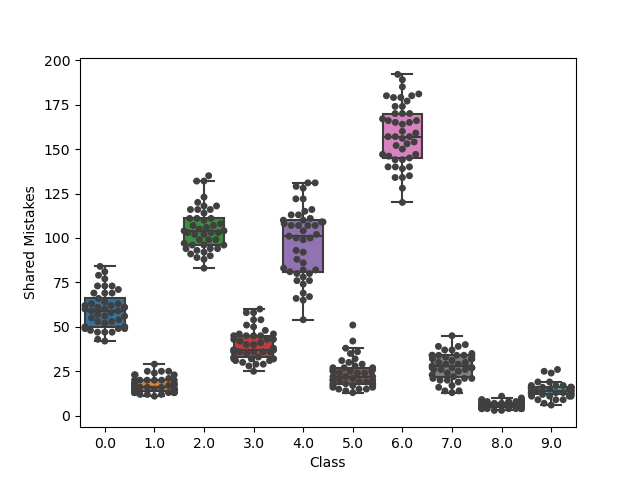

/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 53.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warni

<IPython.core.display.Javascript object>


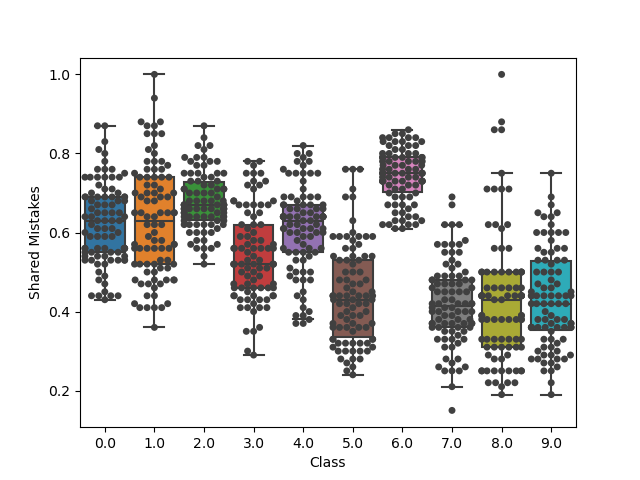

/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/labs/ahissarlab/orra/.conda/envs/orra_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warn

<IPython.core.display.Javascript object>


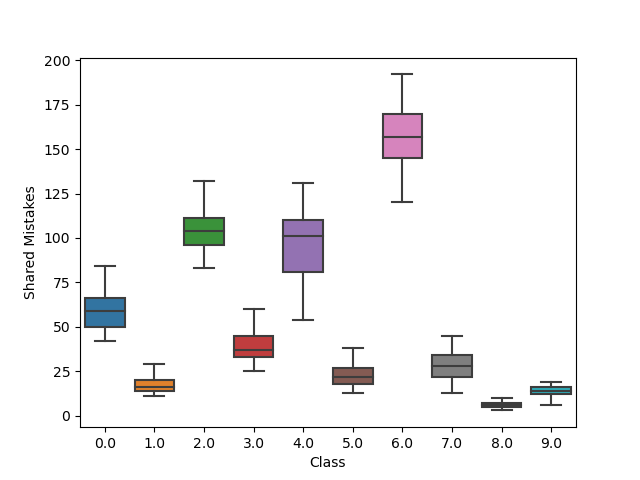

<IPython.core.display.Javascript object>


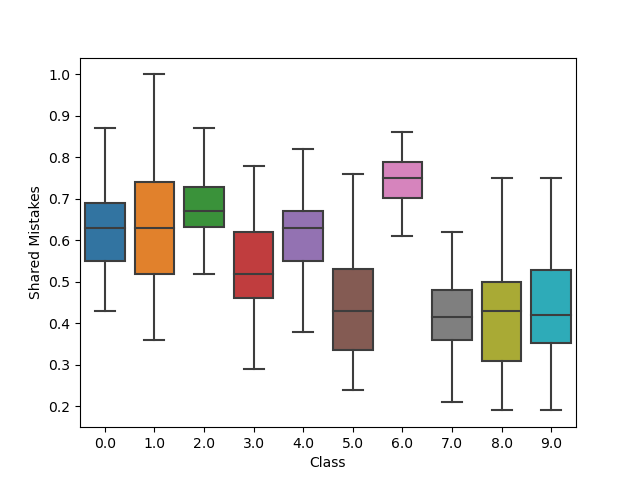

In [15]:
#Find the best trajectory and best seed for each class and also the variance in the common mistakes - in general,
#between the two best and between the two worst.
#Find the differences for each particular label - ex. for label 5 what missclassification did run 1 did 
#compared to run 2? i.e. can we find a trajectory that was particularly different for a distinct class? 
#or are all the classes exsibit simillar veriance? 

very_particular_confusion = np.ones([10,len(indices1), len(indices1)])
very_particular_confusion_percent = np.ones([10,len(indices1), len(indices1)])
run = 1
data_list = []
plot_list = pd.DataFrame(columns = ['Class', "Shared Mistakes"])
plot_list_percent = pd.DataFrame(columns = ['Class', "Shared Mistakes"])
for class_ in range(10):
    for i in range(len(indices1)):
        for j in range(len(indices1)):         
                class_indices = np.where(np.array(test_dataset.labels) == np.array(class_))[0]
                #get only the misslabeled indices for class_ from i
                i_indices = [k for k in indices1[i] if k in class_indices]
                #see how many are similar between i and j in class_
                similar = [l for l in i_indices if l in indices1[j]]
                very_particular_confusion[class_, i, j] = len(similar)
    #General statistics on the class########################################################################
    diagonal = np.diagonal(very_particular_confusion[class_,:,:])
    mean_class = np.mean(diagonal)
    std_class = np.round(np.std(diagonal), decimals = 3)
    best_class = np.min(diagonal)
    best_class_index = np.argmin(diagonal)
    worst_class = np.max(diagonal)
    worst_class_index = np.argmax(diagonal)
    #General Statistics on shared mistakes in the class ###################################################
    #The matrix is symetric so only one side matters
    triangulate = np.tril(very_particular_confusion[class_,:,:], -1)
    lower = triangulate.reshape(triangulate.shape[0]*triangulate.shape[1]).tolist()
    lower = [l for l in lower if l !=0] #Get only non-zero values
    #save lower to plot later 
    plot_data = np.array([np.ones(len(lower))*class_,lower]).T
    plot_data = pd.DataFrame(plot_data, columns = ['Class', "Shared Mistakes"])
    plot_list = plot_list.append(plot_data)
    mean_shared = np.mean(lower)
    std_shared = np.round(np.std(lower), decimals = 3)
    min_shared = np.min(triangulate[np.nonzero(triangulate)])
    r,t = np.where( triangulate==np.min(triangulate[np.nonzero(triangulate)]))
    min_shared_index = (int(r[0]),int(t[0]))
    max_shared = np.max(triangulate)
    max_shared_index = np.unravel_index(np.argmax(triangulate, axis=None), triangulate.shape)
    #Get % Matrix #########################################################################################
    very_particular_confusion_percent[class_, :,:] = very_particular_confusion[class_,:,:]*1
    for i in range(len(indices1)):
        very_particular_confusion_percent[class_, i, :] /= very_particular_confusion_percent[class_, i, i] 
        
    very_particular_confusion_percent = np.round(very_particular_confusion_percent, decimals = 2)
    temp = very_particular_confusion_percent[class_, :,:] * 1
    np.fill_diagonal(temp, 0) # zero out the diagonal
    temp = temp.reshape(temp.shape[0]*temp.shape[1]).tolist()
    no_diagonal = [l for l in temp if l !=0] #Get only non-zero values
    mean_shared = np.mean(no_diagonal)
    std_shared_per = np.round(np.std(no_diagonal), decimals = 3)
    min_shared_per = np.min(no_diagonal)
    min_shared_index_per = np.argmin(no_diagonal)
    max_shared_pre = np.max(no_diagonal)
    max_shared_index_per = np.argmax(no_diagonal)
    #save no_diagonal to plot later
    plot_data_percent = np.array([np.ones(len(no_diagonal))*class_,no_diagonal]).T
    plot_data_percent = pd.DataFrame(plot_data_percent, columns = ['Class', "Shared Mistakes"])
    plot_list_percent = plot_list_percent.append(plot_data_percent)
    #Find the BEST trajectory for this class ##############################################################
    #get the two best run (min number of mistakes)
    min_mistakes = np.partition(diagonal, 1)[:2]
    indx1 = np.argwhere(diagonal == min_mistakes[0])
    indx2 = np.argwhere(diagonal == min_mistakes[1])
    #Get the shared mistakes between them
    two_best_shared = very_particular_confusion_percent[class_,indx1, indx2][0][0]
    #print('On run {} - for class {} the two BEST trajectories misslabeled {} imgs \n {} were shared'.format(
    #                                                run, class_, min_mistakes, shared))
    #Find the WORST trajectory for this class ############################################################
    #get the two best run (min number of mistakes)
    max_mistakes = np.partition(diagonal, 1)[-2:]
    indx1 = np.argwhere(diagonal == max_mistakes[0])
    indx2 = np.argwhere(diagonal == max_mistakes[1])
    #Get the shared mistakes between them
    two_worst_shared = very_particular_confusion_percent[class_,indx1, indx2][0][0]
    #print('On run {} - for class {} the two WORST trajectories misslabeled {} imgs \n {} were shared'.format(
    #                                                run, class_, max_mistakes, shared))
    data_list.append([mean_class,
                      std_class,
                      best_class,
                      best_class_index,
                      worst_class,
                      worst_class_index,
                      mean_shared,
                      std_shared,
                      min_shared,
                      min_shared_index,
                      max_shared,
                      max_shared_index,
                      mean_shared,
                      std_shared_per,
                      min_shared_per,
                      min_shared_index_per,
                      max_shared_pre,
                      max_shared_index_per,
                      two_best_shared,
                      two_worst_shared
                     ])
Database = pd.DataFrame(data_list,  columns = [
                    'Mean Class','std Class',
                    'Best Run','Best Run Index', 'Worst Run','Worst Run Index', 
                    'Mean Shared', 'std Shared','Min Shared', 'Min Shared Index','Max Shared','Max Shared Index',
                    'Mean Shared %', 'std Shared %', 'Min Shared %','Min Shared % Index', 'Max Shared %','Max Shared % Index',
                     '2 Best shared %', '2 Worst Shared %',])
Database
#plot very_particular_confusion ################################################################################
import seaborn as sns
plt.figure()
ax = sns.boxplot(x="Class", y="Shared Mistakes", data=pd.DataFrame(plot_list), showfliers = False)
ax = sns.swarmplot(x="Class", y="Shared Mistakes", data=pd.DataFrame(plot_list), color=".25")
plt.show()
plt.savefig('confusion_fmnist_restart_{}.png'.format(times))
#plot very_particular_confusion_percentage ######################################################################
plt.figure()
ax = sns.boxplot(x="Class", y="Shared Mistakes", data=plot_list_percent, showfliers = False)
ax = sns.swarmplot(x="Class", y="Shared Mistakes", data=plot_list_percent, color=".25")
plt.show()
plt.savefig('confusion_percent_fmnist_restart_{}.png'.format(times))
plt.figure()
ax = sns.boxplot(x="Class", y="Shared Mistakes", data=pd.DataFrame(plot_list), showfliers = False)
plt.show()
plt.savefig('confusion_fmnist_restart2_{}.png'.format(times))
#plot very_particular_confusion_percentage ######################################################################
plt.figure()
ax = sns.boxplot(x="Class", y="Shared Mistakes", data=plot_list_percent, showfliers = False)
plt.show()
plt.savefig('confusion_percent_fmnist_restart2_{}.png'.format(times))

In [16]:
Database = Database.round(decimals = 2)
Database.to_pickle('restart_sum_data.pickle')
Database

,Mean Class,std Class,Best Run,Best Run Index,Worst Run,Worst Run Index,Mean Shared,std Shared,Min Shared,Min Shared Index,Max Shared,Max Shared Index,Mean Shared %,std Shared %,Min Shared %,Min Shared % Index,Max Shared %,Max Shared % Index,2 Best shared %,2 Worst Shared %
0,97.3,19.10,70.0,8,131.0,1,0.62,10.34,42.0,"(8, 5)",84.0,"(7, 1)",0.62,0.10,0.43,43,0.87,28,0.60,0.68
1,28.2,6.49,17.0,4,39.0,6,0.63,4.30,11.0,"(9, 3)",29.0,"(6, 2)",0.63,0.14,0.36,58,1.00,40,0.88,0.50
2,155.9,20.25,132.0,4,206.0,8,0.68,11.94,83.0,"(4, 0)",135.0,"(8, 2)",0.68,0.07,0.52,76,0.87,25,0.63,0.56
3,75.8,20.15,48.0,8,124.0,0,0.54,8.56,25.0,"(8, 1)",60.0,"(6, 0)",0.54,0.12,0.29,16,0.78,18,0.67,0.44
4,162.7,32.67,102.0,1,204.0,5,0.61,19.55,54.0,"(6, 1)",131.0,"(5, 2)",0.61,0.11,0.37,64,0.82,61,0.53,0.60
5,55.4,18.08,34.0,7,99.0,6,0.44,7.82,13.0,"(4, 2)",51.0,"(9, 6)",0.44,0.12,0.24,60,0.76,5,0.44,0.59
6,213.9,21.27,174.0,9,245.0,1,0.74,17.20,120.0,"(9, 7)",192.0,"(3, 1)",0.74,0.07,0.61,8,0.86,82,0.69,0.83
7,67.9,16.93,42.0,6,96.0,4,0.42,7.50,13.0,"(6, 0)",45.0,"(7, 4)",0.42,0.10,0.15,23,0.69,67,0.31,0.36
8,15.4,4.76,7.0,9,24.0,1,0.43,1.88,3.0,"(9, 0)",11.0,"(3, 1)",0.43,0.16,0.19,8,1.00,85,0.43,0.22
9,34.5,8.08,20.0,4,45.0,8,0.43,4.01,6.0,"(9, 4)",26.0,"(6, 1)",0.43,0.12,0.19,85,0.75,36,0.60,0.31


In [30]:
Database.iloc[:
              ,:6]

,Mean Class,std Class,Best Run,Best Run Index,Worst Run,Worst Run Index
0,97.3,19.10,70.0,8,131.0,1
1,28.2,6.49,17.0,4,39.0,6
2,155.9,20.25,132.0,4,206.0,8
3,75.8,20.15,48.0,8,124.0,0
4,162.7,32.67,102.0,1,204.0,5
5,55.4,18.08,34.0,7,99.0,6
6,213.9,21.27,174.0,9,245.0,1
7,67.9,16.93,42.0,6,96.0,4
8,15.4,4.76,7.0,9,24.0,1
9,34.5,8.08,20.0,4,45.0,8


In [32]:
[
                    'Mean Class','std Class',
                    'Best Run','Best Run Index', 'Worst Run','Worst Run Index', 
                    'Mean Shared', 'std Shared','Min Shared', 'Min Shared Index','Max Shared','Max Shared Index',
                    'Mean Shared %', 'std Shared %', 'Min Shared %','Min Shared % Index', 'Max Shared %','Max Shared % Index',
                     '2 Best shared %', '2 Worst Shared %',]
Database.iloc[:
              ,6:]

,Mean Shared,std Shared,Min Shared,Min Shared Index,Max Shared,Max Shared Index,Mean Shared %,std Shared %,Min Shared %,Min Shared % Index,Max Shared %,Max Shared % Index,2 Best shared %,2 Worst Shared %
0,0.62,10.34,42.0,"(8, 5)",84.0,"(7, 1)",0.62,0.10,0.43,43,0.87,28,0.60,0.68
1,0.63,4.30,11.0,"(9, 3)",29.0,"(6, 2)",0.63,0.14,0.36,58,1.00,40,0.88,0.50
2,0.68,11.94,83.0,"(4, 0)",135.0,"(8, 2)",0.68,0.07,0.52,76,0.87,25,0.63,0.56
3,0.54,8.56,25.0,"(8, 1)",60.0,"(6, 0)",0.54,0.12,0.29,16,0.78,18,0.67,0.44
4,0.61,19.55,54.0,"(6, 1)",131.0,"(5, 2)",0.61,0.11,0.37,64,0.82,61,0.53,0.60
5,0.44,7.82,13.0,"(4, 2)",51.0,"(9, 6)",0.44,0.12,0.24,60,0.76,5,0.44,0.59
6,0.74,17.20,120.0,"(9, 7)",192.0,"(3, 1)",0.74,0.07,0.61,8,0.86,82,0.69,0.83
7,0.42,7.50,13.0,"(6, 0)",45.0,"(7, 4)",0.42,0.10,0.15,23,0.69,67,0.31,0.36
8,0.43,1.88,3.0,"(9, 0)",11.0,"(3, 1)",0.43,0.16,0.19,8,1.00,85,0.43,0.22
9,0.43,4.01,6.0,"(9, 4)",26.0,"(6, 1)",0.43,0.12,0.19,85,0.75,36,0.60,0.31


In [17]:
very_particular_confusion

array([[[ 85.,  69.,  64.,  50.,  63.,  47.,  59.,  63.,  48.,  58.],
        [ 69., 131.,  77.,  69.,  79.,  57.,  73.,  84.,  61.,  73.],
        [ 64.,  77.,  93.,  55.,  62.,  50.,  61.,  69.,  52.,  59.],
        [ 50.,  69.,  55.,  79.,  56.,  43.,  54.,  60.,  47.,  49.],
        [ 63.,  79.,  62.,  56., 117.,  53.,  66.,  81.,  50.,  61.],
        [ 47.,  57.,  50.,  43.,  53.,  77.,  53.,  60.,  42.,  49.],
        [ 59.,  73.,  61.,  54.,  66.,  53.,  96.,  73.,  47.,  62.],
        [ 63.,  84.,  69.,  60.,  81.,  60.,  73., 113.,  56.,  71.],
        [ 48.,  61.,  52.,  47.,  50.,  42.,  47.,  56.,  70.,  49.],
        [ 58.,  73.,  59.,  49.,  61.,  49.,  62.,  71.,  49., 112.]],

       [[ 23.,  13.,  18.,  15.,  15.,  20.,  18.,  12.,  16.,  16.],
        [ 13.,  25.,  18.,  17.,  12.,  15.,  20.,  14.,  13.,  12.],
        [ 18.,  18.,  34.,  21.,  16.,  25.,  29.,  23.,  25.,  15.],
        [ 15.,  17.,  21.,  26.,  13.,  17.,  20.,  15.,  18.,  11.],
        [ 15.,  12

In [18]:
very_particular_confusion_percent

array([[[1.  , 0.81, 0.75, 0.59, 0.74, 0.55, 0.69, 0.74, 0.56, 0.68],
        [0.53, 1.  , 0.59, 0.53, 0.6 , 0.44, 0.56, 0.64, 0.47, 0.56],
        [0.69, 0.83, 1.  , 0.59, 0.67, 0.54, 0.66, 0.74, 0.56, 0.63],
        [0.63, 0.87, 0.7 , 1.  , 0.71, 0.54, 0.68, 0.76, 0.59, 0.62],
        [0.54, 0.68, 0.53, 0.48, 1.  , 0.45, 0.56, 0.69, 0.43, 0.52],
        [0.61, 0.74, 0.65, 0.56, 0.69, 1.  , 0.69, 0.78, 0.55, 0.64],
        [0.61, 0.76, 0.64, 0.56, 0.69, 0.55, 1.  , 0.76, 0.49, 0.65],
        [0.56, 0.74, 0.61, 0.53, 0.72, 0.53, 0.65, 1.  , 0.5 , 0.63],
        [0.69, 0.87, 0.74, 0.67, 0.71, 0.6 , 0.67, 0.8 , 1.  , 0.7 ],
        [0.52, 0.65, 0.53, 0.44, 0.54, 0.44, 0.55, 0.63, 0.44, 1.  ]],

       [[1.  , 0.57, 0.78, 0.65, 0.65, 0.87, 0.78, 0.52, 0.7 , 0.7 ],
        [0.52, 1.  , 0.72, 0.68, 0.48, 0.6 , 0.8 , 0.56, 0.52, 0.48],
        [0.53, 0.53, 1.  , 0.62, 0.47, 0.74, 0.85, 0.68, 0.74, 0.44],
        [0.58, 0.65, 0.81, 1.  , 0.5 , 0.65, 0.77, 0.58, 0.69, 0.42],
        [0.88, 0.7

In [20]:
indx2

array([[9]])